# House price prediction using linear regression (minimal)

Using the boston housing dataset: https://www.kaggle.com/c/boston-housing/

In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
#!pip install jovian --upgrade --quiet

In [3]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
# Hyperparameters
batch_size=64
learning_rate=5e-7


# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

## Dataset & Data loaders

In [6]:
# Download the data
path =  '../datasets/'
download_url(DATASET_URL, path)
dataframe = pd.read_csv(path + DATA_FILENAME)
dataframe.head()

Using downloaded and verified file: ../datasets/BostonHousing.csv


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [8]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

## Model

In [9]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
model = HousingModel()

## Training

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
result = evaluate(model, val_loader)
result

{'val_loss': 11524.9052734375}

In [12]:
history = fit(10, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 558.8557
Epoch [1], val_loss: 418.6295
Epoch [2], val_loss: 334.7383
Epoch [3], val_loss: 274.5057
Epoch [4], val_loss: 233.5002
Epoch [5], val_loss: 200.3565
Epoch [6], val_loss: 175.9940
Epoch [7], val_loss: 158.6664
Epoch [8], val_loss: 144.6396
Epoch [9], val_loss: 135.2019


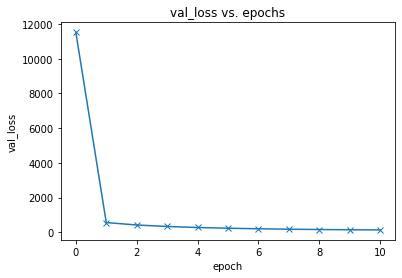

In [13]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

In [14]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [15]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([8.4921e+00, 0.0000e+00, 1.8100e+01, 0.0000e+00, 5.8400e-01, 6.3480e+00,
        8.6100e+01, 2.0527e+00, 2.4000e+01, 6.6600e+02, 2.0200e+01, 8.3450e+01,
        1.7640e+01])
Target:  14.5
Prediction: 17.195371627807617


## Save and upload

In [16]:
torch.save(model.state_dict(), 'housing-linear.pth')

In [20]:
import os
cwd = os.getcwd()
print(cwd)

d:\Repos\PhD\2020_jovian_deep_learning\w2_housing-linear-minimal-v-1


In [21]:
# jovian.commit(project='housing-linear-minimal', environment=None, outputs=['housing-linear.pth'])
# jovian.commit(project='housing-linear-minimal', environment=None, outputs=['housing-linear.pth']) # Kaggle commit fails sometimes, so try again..
jovian.commit(message="week 2 - housing-linear-minimal project", 
              filename="notebook_source__", project="leosf/housing-linear-minimal",
              outputs=['housing-linear.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "leosf/housing-linear-minimal" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ml/leosf/housing-linear-minimal


'https://jovian.ml/leosf/housing-linear-minimal'